In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from tensorflow.keras.applications import ResNet152V2
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.metrics import Precision, Recall
from sklearn.metrics import f1_score
import keras.backend as K
from glob import glob

# re-size all the images to this
IMAGE_SIZE = [224, 224]

# add preprocessing layer to the front of resnet
resnet = ResNet152V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in resnet.layers:
  layer.trainable = False


# our layers - you can add more if you want
x = Flatten()(resnet.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(4, activation='softmax')(x)

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

# view the structure of the model
model.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_7[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                            

In [ ]:

from tensorflow.keras.callbacks import EarlyStopping

# Specify early stopping callback monitoring validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)



# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy', Precision(), Recall()]
)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
batch_size=64

train_dir = '/content/drive/MyDrive/Cotton_Dataset/train'
test_dir = '/content/drive/MyDrive/Cotton_Dataset/test'
val_dir = '/content/drive/MyDrive/Cotton_Dataset/val'

train_datagen = ImageDataGenerator(rescale =1./255,
                                   #vertical_flip =True,
                                  # horizontal_flip = True,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range=40,  # Rotation by up to 60 degrees
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')


training_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)


test_datagen = ImageDataGenerator(rescale =1./255)

testing_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_set = test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 1196 images belonging to 4 classes.
Found 256 images belonging to 4 classes.
Found 257 images belonging to 4 classes.


In [ ]:
epochs = 29
history = model.fit(
    training_set,
    epochs=epochs,
    #callbacks=[early_stopping],
    validation_data=validation_set,
    steps_per_epoch=len(training_set),
    validation_steps=len(validation_set)
)



Epoch 1/29
19/19 [==============================] - 39s 2s/step - loss: 5.2908 - accuracy: 0.6162 - precision_6: 0.6220 - recall_6: 0.6137 - val_loss: 1.5603 - val_accuracy: 0.8599 - val_precision_6: 0.8599 - val_recall_6: 0.8599
Epoch 2/29
19/19 [==============================] - 25s 1s/step - loss: 1.0212 - accuracy: 0.8645 - precision_6: 0.8673 - recall_6: 0.8637 - val_loss: 0.8762 - val_accuracy: 0.8794 - val_precision_6: 0.8828 - val_recall_6: 0.8794
Epoch 3/29
19/19 [==============================] - 25s 1s/step - loss: 0.6933 - accuracy: 0.8938 - precision_6: 0.8945 - recall_6: 0.8930 - val_loss: 0.4676 - val_accuracy: 0.9377 - val_precision_6: 0.9377 - val_recall_6: 0.9377
Epoch 4/29
19/19 [==============================] - 25s 1s/step - loss: 0.4651 - accuracy: 0.9273 - precision_6: 0.9272 - recall_6: 0.9264 - val_loss: 0.5452 - val_accuracy: 0.9222 - val_precision_6: 0.9258 - val_recall_6: 0.9222
Epoch 5/29
19/19 [==============================] - 26s 1s/step - loss: 0.4610 -

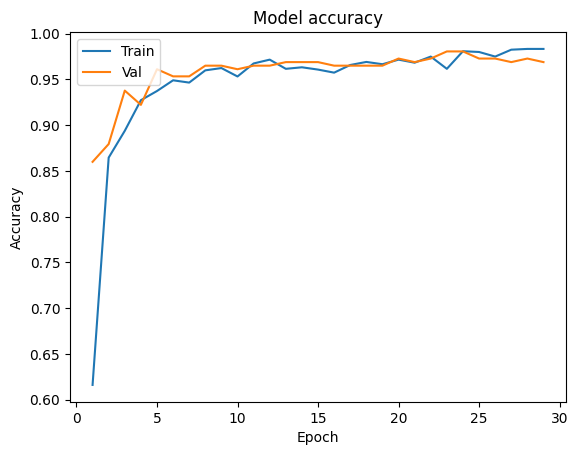

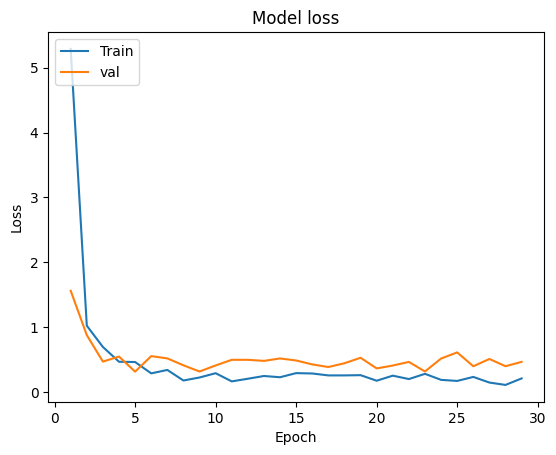

In [ ]:
import matplotlib.pyplot as plt

def plot_learningCurve(history, epoch):
# Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
#Plot training & validation Loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'val'], loc='upper left')
  plt.show()


plot_learningCurve(history, epochs)

In [ ]:
model.save('/content/drive/MyDrive/Saved_Model/res152(bs64e29).h5')